# Stage 5: Short-Only Strategy with Modular Pipeline

## Architecture
```
raw_data → Stage1 (Short Features) → features.parquet
         → Stage2 (Walk-Forward Training) → predictions.parquet  
         → Stage3 (Backtest) → results
```

## Key Principles
1. **No look-ahead bias**: Signal at T uses only data up to T
2. **Proper timing**: Signal T → Trade T+1 → Earn return T to T+1
3. **Short-specific features**: Overextension, exhaustion, distribution patterns
4. **Walk-forward training**: Quarterly retrains (fewer = less overfit)
5. **Rigorous backtester**: Transaction costs, turnover tracking

In [11]:
# ============================================================================
# IMPORTS AND CONFIGURATION
# ============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import warnings
import importlib
warnings.filterwarnings('ignore')

# Add src to path
BASE_DIR = Path.cwd().parent.parent
sys.path.insert(0, str(BASE_DIR / 'src'))

# Import modular components (with reload for development)
import modular.features_long as features_long_mod
import modular.features_short as features_short_mod
import modular.walk_forward as walk_forward_mod
import modular.backtester as backtester_mod

importlib.reload(features_long_mod)
importlib.reload(features_short_mod)
importlib.reload(walk_forward_mod)
importlib.reload(backtester_mod)

from modular.features_long import LongFeatureEngineer
from modular.features_short import ShortFeatureEngineer
from modular.walk_forward import WalkForwardTrainer
from modular.backtester import Backtester, BacktestConfig, validate_no_lookahead

# Paths
DATA_DIR = BASE_DIR / 'data'
PROCESSED_DIR = DATA_DIR / 'processed'
OUTPUT_DIR = BASE_DIR / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures' / 'stage5_short'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Configuration
IS_END = pd.Timestamp('2023-12-31')
OOS_START = pd.Timestamp('2024-01-01')

plt.style.use('seaborn-v0_8-whitegrid')
print("="*70)
print(" STAGE 5: SHORT-ONLY STRATEGY WITH MODULAR PIPELINE")
print("="*70)

 STAGE 5: SHORT-ONLY STRATEGY WITH MODULAR PIPELINE


## Stage 1: Load Data and Compute Short Features

In [4]:
# ============================================================================
# LOAD RAW DATA
# ============================================================================
print("Loading raw data...")

# Try multiple possible data files
data_files = [
    PROCESSED_DIR / 'df_after_eda.parquet',
    PROCESSED_DIR / 'stage1_5_targets.parquet',
    DATA_DIR / 'raw' / 'daily_prices.csv'
]

df = None
for f in data_files:
    if f.exists():
        if f.suffix == '.parquet':
            df = pd.read_parquet(f)
        else:
            df = pd.read_csv(f)
        print(f"Loaded: {f}")
        break

if df is None:
    raise FileNotFoundError("No data file found!")

# Standardize column names
if 'Date' in df.columns and 'date' not in df.columns:
    df = df.rename(columns={'Date': 'date'})
if 'asset_id' in df.columns and 'ticker' not in df.columns:
    df = df.rename(columns={'asset_id': 'ticker'})

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date'])

print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Tickers: {df['ticker'].nunique()}")
print(f"Columns: {df.columns.tolist()[:10]}...")

Loading raw data...
Loaded: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\df_after_eda.parquet
Data shape: (251100, 10)
Date range: 2016-01-25 to 2026-01-16
Tickers: 100
Columns: ['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ticker', 'year', 'returns', 'log_returns']...


In [5]:
# ============================================================================
# COMPUTE SHORT-SPECIFIC FEATURES
# ============================================================================
print("\n" + "="*50)
print(" STAGE 1: SHORT FEATURE ENGINEERING")
print("="*50)

# Initialize short feature engineer
short_engineer = ShortFeatureEngineer(df)

# Compute all features
df_short = short_engineer.compute_all_features()

# Get feature columns
short_features = short_engineer.get_feature_columns()
print(f"\nShort features computed: {len(short_features)}")
print(f"Features: {short_features[:10]}...")


 STAGE 1: SHORT FEATURE ENGINEERING
Computing overextension features...
Computing exhaustion features...
Computing distribution features...
Computing volatility features...
Computing squeeze risk features...
✅ Computed 20 short features

Short features computed: 20
Features: ['short_near_52w_high_zscore', 'short_mom_decel_5v21_zscore', 'short_overext_ma_21d_zscore', 'short_above_bb_21d_zscore', 'short_closing_weakness_zscore', 'short_overext_ma_50d_zscore', 'short_channel_pos_63d_zscore', 'short_obv_divergence_zscore', 'short_channel_pos_21d_zscore', 'short_squeeze_risk_dd_zscore']...


In [6]:
# ============================================================================
# CREATE TARGET VARIABLE
# ============================================================================
print("\nCreating target variable...")

# Forward returns at different horizons
for horizon in [1, 5, 10, 21]:
    col = f'fwd_ret_{horizon}d'
    if col not in df_short.columns:
        df_short[col] = df_short.groupby('ticker')['Close'].transform(
            lambda x: x.shift(-horizon) / x - 1
        )

# Target: 5-day forward return (cross-sectionally z-scored)
df_short['target'] = df_short.groupby('date')['fwd_ret_5d'].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-10)
).clip(-3, 3)

print(f"Target created: fwd_ret_5d (z-scored)")


Creating target variable...
Target created: fwd_ret_5d (z-scored)


In [7]:
# ============================================================================
# SAVE STAGE 1 OUTPUT
# ============================================================================
stage1_output = PROCESSED_DIR / 'stage1_short_features.parquet'
short_engineer.df = df_short
short_engineer.save_features(str(stage1_output))
print(f"\n✅ Stage 1 complete: {stage1_output}")

✅ Saved features to c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_short_features.parquet

✅ Stage 1 complete: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage1_short_features.parquet


## Stage 2: Walk-Forward Model Training

In [8]:
# ============================================================================
# PREPARE DATA FOR TRAINING
# ============================================================================
print("\n" + "="*50)
print(" STAGE 2: WALK-FORWARD TRAINING")
print("="*50)

# Split IS/OOS
is_data = df_short[df_short['date'] <= IS_END].copy()
oos_data = df_short[df_short['date'] >= OOS_START].copy()

print(f"\nIS Data: {len(is_data):,} rows, {is_data['date'].nunique()} days")
print(f"OOS Data: {len(oos_data):,} rows, {oos_data['date'].nunique()} days")

# Feature columns (only use z-scored features)
feature_cols = [c for c in short_features if c.endswith('_zscore')]
print(f"\nUsing {len(feature_cols)} features for training")


 STAGE 2: WALK-FORWARD TRAINING

IS Data: 199,800 rows, 1998 days
OOS Data: 51,300 rows, 513 days

Using 20 features for training


In [12]:
# ============================================================================
# TRAIN SHORT-ONLY MODEL
# ============================================================================
print("\nTraining short model with walk-forward...")

# Initialize trainer on IS data
trainer = WalkForwardTrainer(
    df=is_data,
    feature_cols=feature_cols,
    target_col='target',
    date_col='date',
    ticker_col='ticker'
)

# Train with quarterly rebalancing (fewer retrains = less overfit)
is_predictions = trainer.train_predict(
    model_type='lgbm',
    model_params={
        'n_estimators': 150,
        'max_depth': 5,
        'learning_rate': 0.03,
        'num_leaves': 25,
        'min_child_samples': 50
    },
    retrain_freq_days=63,  # Quarterly
    min_train_days=252,     # 1 year minimum
    embargo_days=5,         # 5-day gap
    expanding_window=True
)

print(f"\nIS predictions: {len(is_predictions):,}")


Training short model with walk-forward...
Walk-forward training: LGBM
  Retrain frequency: 63 days
  Min training window: 252 days
  Embargo: 5 days
  Window type: Expanding
  Retrain dates: 25

✅ Walk-forward training complete
  Predictions: 151,900
  Average IC: 0.0030

IS predictions: 151,900


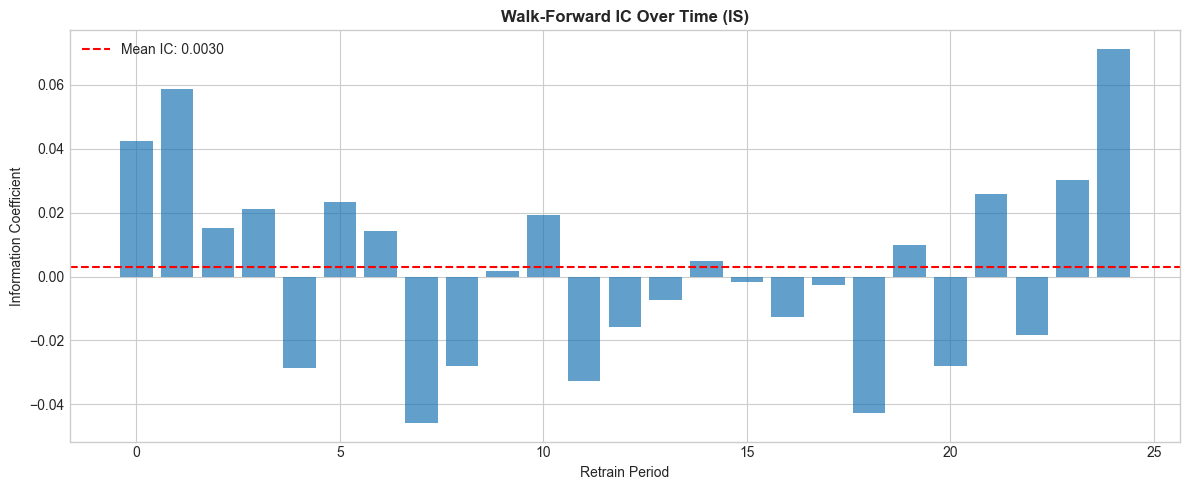


IC Statistics:
  Mean: 0.0030
  Std:  0.0301
  Min:  -0.0458
  Max:  0.0712


In [13]:
# ============================================================================
# DIAGNOSTICS: IC OVER TIME
# ============================================================================
diags = trainer.get_diagnostics()

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(range(len(diags)), diags['ic'], alpha=0.7)
ax.axhline(y=diags['ic'].mean(), color='red', linestyle='--', label=f"Mean IC: {diags['ic'].mean():.4f}")
ax.set_title('Walk-Forward IC Over Time (IS)', fontweight='bold')
ax.set_xlabel('Retrain Period')
ax.set_ylabel('Information Coefficient')
ax.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'is_ic_over_time.png', dpi=150)
plt.show()

print(f"\nIC Statistics:")
print(f"  Mean: {diags['ic'].mean():.4f}")
print(f"  Std:  {diags['ic'].std():.4f}")
print(f"  Min:  {diags['ic'].min():.4f}")
print(f"  Max:  {diags['ic'].max():.4f}")

In [14]:
# ============================================================================
# GENERATE OOS PREDICTIONS
# ============================================================================
print("\nGenerating OOS predictions...")

# Use same trainer to generate OOS predictions
# (model trained on all IS data)
oos_trainer = WalkForwardTrainer(
    df=oos_data,
    feature_cols=feature_cols,
    target_col='target',
    date_col='date',
    ticker_col='ticker'
)

# Use model from IS training
from sklearn.preprocessing import StandardScaler

# Prepare OOS features
oos_valid = oos_data.dropna(subset=feature_cols)
X_oos = oos_valid[feature_cols].values
X_oos = np.nan_to_num(X_oos, nan=0.0)

# Scale using IS statistics
is_valid = is_data.dropna(subset=feature_cols)
X_is = is_valid[feature_cols].values
X_is = np.nan_to_num(X_is, nan=0.0)
scaler = StandardScaler().fit(X_is)
X_oos_scaled = scaler.transform(X_oos)

# Predict using trained model
if 'lgbm' in trainer.trained_models:
    oos_preds = trainer.trained_models['lgbm'].predict(X_oos_scaled)
    
    oos_predictions = oos_valid[['date', 'ticker']].copy()
    oos_predictions['prediction'] = oos_preds
    oos_predictions['signal_zscore'] = oos_predictions.groupby('date')['prediction'].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-10)
    ).clip(-3, 3)
    
    print(f"OOS predictions: {len(oos_predictions):,}")


Generating OOS predictions...
OOS predictions: 51,300


In [15]:
# ============================================================================
# COMBINE IS + OOS AND SAVE
# ============================================================================
all_predictions = pd.concat([is_predictions, oos_predictions], ignore_index=True)
all_predictions = all_predictions.drop_duplicates(subset=['date', 'ticker'], keep='last')

# Merge with return data for backtesting
return_cols = ['date', 'ticker', 'fwd_ret_1d', 'fwd_ret_5d']
return_cols = [c for c in return_cols if c in df_short.columns]

predictions_with_returns = all_predictions.merge(
    df_short[return_cols],
    on=['date', 'ticker'],
    how='left'
)

# For SHORT strategy, we want to SHORT stocks with HIGH signal
# The signal is already oriented as "higher = more shortable"
predictions_with_returns['short_signal'] = predictions_with_returns['signal_zscore']

stage2_output = PROCESSED_DIR / 'stage2_short_predictions.parquet'
predictions_with_returns.to_parquet(stage2_output, index=False)
print(f"\n✅ Stage 2 complete: {stage2_output}")


✅ Stage 2 complete: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\stage2_short_predictions.parquet


## Stage 3: Backtesting

In [16]:
# ============================================================================
# VALIDATE NO LOOK-AHEAD BIAS
# ============================================================================
print("\n" + "="*50)
print(" STAGE 3: BACKTESTING")
print("="*50)

print("\n🔍 Validating no look-ahead bias...")
validate_no_lookahead(
    predictions_with_returns.dropna(subset=['short_signal', 'fwd_ret_1d']),
    signal_col='short_signal',
    return_col='fwd_ret_1d'
)


 STAGE 3: BACKTESTING

🔍 Validating no look-ahead bias...
✅ No obvious look-ahead bias detected (corr: -0.0007)


True

In [17]:
# ============================================================================
# BACKTEST CONFIGURATION
# ============================================================================
config = BacktestConfig(
    initial_capital=1_000_000,
    transaction_cost_bps=10,
    rebalance_freq_days=21,  # Monthly
    top_pct=0.20,  # Short top 20% (highest short signal)
    bottom_pct=0.20,
    signal_col='short_signal',
    return_col='fwd_ret_1d'
)

print(f"\nBacktest Configuration:")
print(f"  Transaction cost: {config.transaction_cost_bps} bps")
print(f"  Rebalance freq: {config.rebalance_freq_days} days")
print(f"  Top %: {config.top_pct*100:.0f}%")


Backtest Configuration:
  Transaction cost: 10 bps
  Rebalance freq: 21 days
  Top %: 20%


In [18]:
# ============================================================================
# RUN SHORT-ONLY BACKTEST (IS)
# ============================================================================
print("\n--- IN-SAMPLE BACKTEST ---")

is_bt_data = predictions_with_returns[predictions_with_returns['date'] <= IS_END]
bt_is = Backtester(is_bt_data, config)

is_results = bt_is.run_short_only(
    signal_col='short_signal',
    bottom_pct=0.20,  # Short top 20% by short signal
    rebalance_freq=21
)

bt_is.print_metrics(is_results, "IS Short-Only Results")


--- IN-SAMPLE BACKTEST ---

 IS Short-Only Results
  Total Return:       -76.7%
  Annual Return:      -21.5%
  Annual Vol:          23.5%
  Sharpe Ratio:       -0.91
  Sortino Ratio:      -1.30
  Calmar Ratio:       -0.28
  Max Drawdown:       -77.2%
  Win Rate:            46.0%
  Annual Turnover:      167
  Trading Days:        1519



In [19]:
# ============================================================================
# RUN SHORT-ONLY BACKTEST (OOS)
# ============================================================================
print("\n--- OUT-OF-SAMPLE BACKTEST ---")

oos_bt_data = predictions_with_returns[predictions_with_returns['date'] >= OOS_START]
bt_oos = Backtester(oos_bt_data, config)

oos_results = bt_oos.run_short_only(
    signal_col='short_signal',
    bottom_pct=0.20,
    rebalance_freq=21
)

bt_oos.print_metrics(oos_results, "OOS Short-Only Results")


--- OUT-OF-SAMPLE BACKTEST ---

 OOS Short-Only Results
  Total Return:       -50.7%
  Annual Return:      -29.4%
  Annual Vol:          20.0%
  Sharpe Ratio:       -1.47
  Sortino Ratio:      -1.87
  Calmar Ratio:       -0.57
  Max Drawdown:       -51.7%
  Win Rate:            41.8%
  Annual Turnover:      156
  Trading Days:         512



In [20]:
# ============================================================================
# STRATEGY COMPARISON
# ============================================================================
print("\n--- STRATEGY COMPARISON ---")

# Also run long-short for comparison
is_ls_results = bt_is.run_long_short(signal_col='short_signal', top_pct=0.20, bottom_pct=0.20)
oos_ls_results = bt_oos.run_long_short(signal_col='short_signal', top_pct=0.20, bottom_pct=0.20)

comparison = pd.DataFrame([
    {'Strategy': 'Short-Only IS', 'Sharpe': is_results.metrics['sharpe'], 
     'Return': is_results.metrics['ann_return'], 'MaxDD': is_results.metrics['max_dd']},
    {'Strategy': 'Short-Only OOS', 'Sharpe': oos_results.metrics['sharpe'],
     'Return': oos_results.metrics['ann_return'], 'MaxDD': oos_results.metrics['max_dd']},
    {'Strategy': 'Long-Short IS', 'Sharpe': is_ls_results.metrics['sharpe'],
     'Return': is_ls_results.metrics['ann_return'], 'MaxDD': is_ls_results.metrics['max_dd']},
    {'Strategy': 'Long-Short OOS', 'Sharpe': oos_ls_results.metrics['sharpe'],
     'Return': oos_ls_results.metrics['ann_return'], 'MaxDD': oos_ls_results.metrics['max_dd']}
])

comparison['Return'] = comparison['Return'].apply(lambda x: f"{x*100:.1f}%")
comparison['MaxDD'] = comparison['MaxDD'].apply(lambda x: f"{x*100:.1f}%")
comparison['Sharpe'] = comparison['Sharpe'].apply(lambda x: f"{x:.2f}")

print(comparison.to_string(index=False))


--- STRATEGY COMPARISON ---
      Strategy Sharpe Return  MaxDD
 Short-Only IS  -0.91 -21.5% -77.2%
Short-Only OOS  -1.47 -29.4% -51.7%
 Long-Short IS   0.21   1.4% -11.5%
Long-Short OOS   1.21   9.7%  -8.3%


✅ Saved: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\figures\stage5_short\short_strategy_results.png


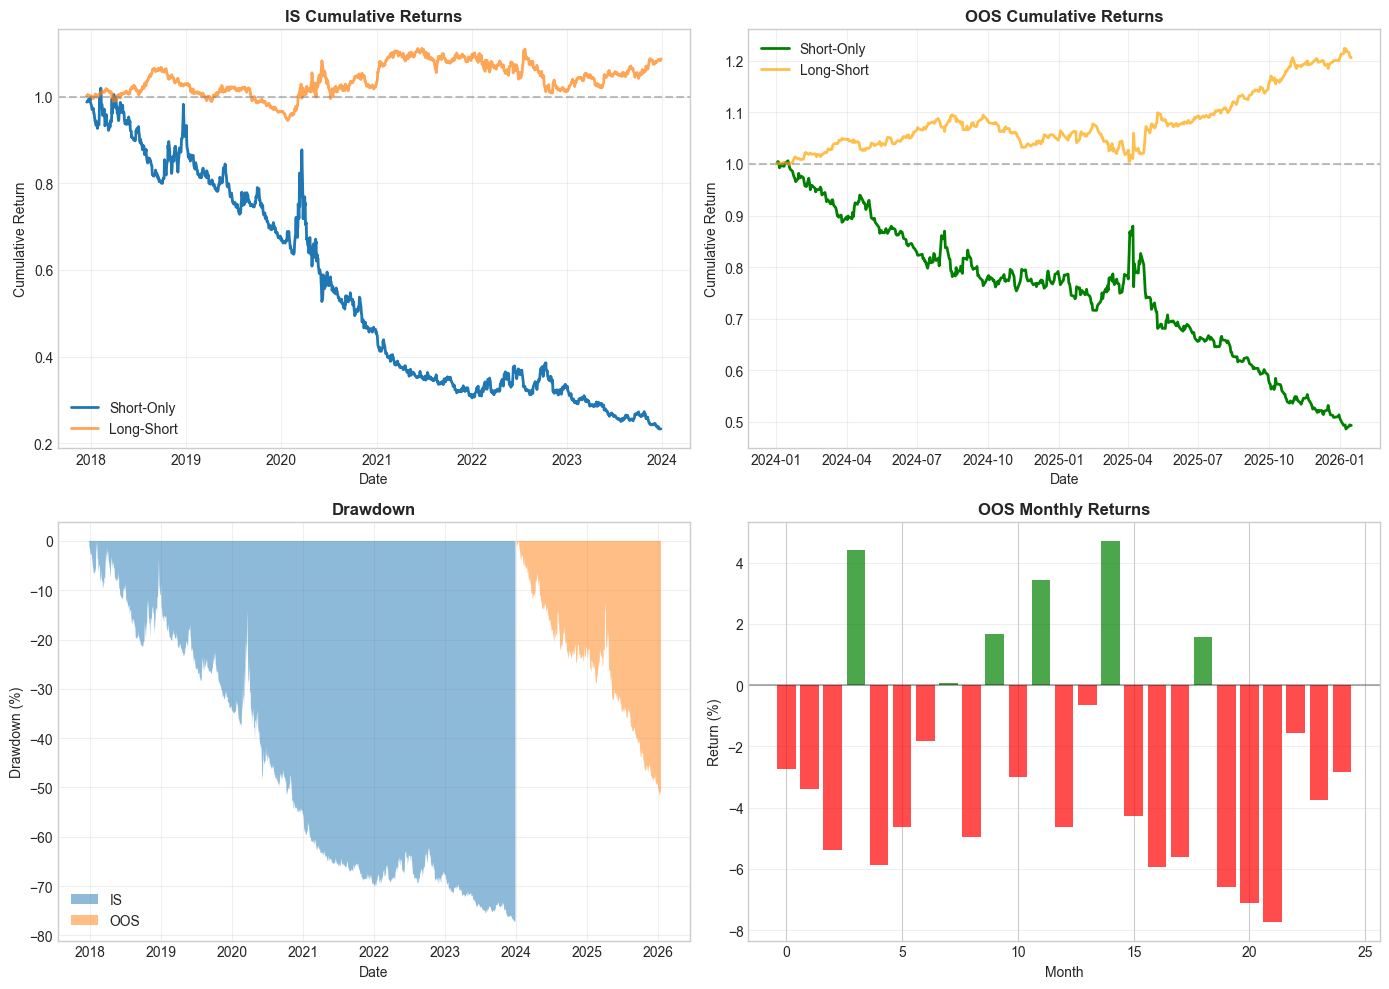

In [21]:
# ============================================================================
# VISUALIZATION
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. IS Cumulative Returns
ax = axes[0, 0]
ax.plot(is_results.daily_returns['date'], is_results.daily_returns['cumulative'], 
        label='Short-Only', linewidth=2)
ax.plot(is_ls_results.daily_returns['date'], is_ls_results.daily_returns['cumulative'],
        label='Long-Short', linewidth=2, alpha=0.7)
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax.set_title('IS Cumulative Returns', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. OOS Cumulative Returns
ax = axes[0, 1]
ax.plot(oos_results.daily_returns['date'], oos_results.daily_returns['cumulative'],
        label='Short-Only', linewidth=2, color='green')
ax.plot(oos_ls_results.daily_returns['date'], oos_ls_results.daily_returns['cumulative'],
        label='Long-Short', linewidth=2, alpha=0.7, color='orange')
ax.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax.set_title('OOS Cumulative Returns', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Drawdown
ax = axes[1, 0]
is_dd = (is_results.daily_returns['cumulative'] / is_results.daily_returns['cumulative'].cummax() - 1) * 100
oos_dd = (oos_results.daily_returns['cumulative'] / oos_results.daily_returns['cumulative'].cummax() - 1) * 100
ax.fill_between(is_results.daily_returns['date'], is_dd, 0, alpha=0.5, label='IS')
ax.fill_between(oos_results.daily_returns['date'], oos_dd, 0, alpha=0.5, label='OOS')
ax.set_title('Drawdown', fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown (%)')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Monthly Returns Heatmap
ax = axes[1, 1]
oos_daily = oos_results.daily_returns.copy()
oos_daily['month'] = oos_daily['date'].dt.to_period('M')
monthly_rets = oos_daily.groupby('month')['net_return'].sum() * 100
ax.bar(range(len(monthly_rets)), monthly_rets.values, 
       color=['green' if x > 0 else 'red' for x in monthly_rets.values], alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_title('OOS Monthly Returns', fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Return (%)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'short_strategy_results.png', dpi=150, bbox_inches='tight')
print(f"✅ Saved: {FIGURES_DIR / 'short_strategy_results.png'}")
plt.show()

## Summary

In [22]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print(" STAGE 5 SUMMARY: SHORT-ONLY STRATEGY")
print("="*70)

print(f"\n📊 DATA:")
print(f"   Total observations: {len(df_short):,}")
print(f"   IS period: {df_short['date'].min().date()} to {IS_END.date()}")
print(f"   OOS period: {OOS_START.date()} to {df_short['date'].max().date()}")

print(f"\n🔧 FEATURES:")
print(f"   Short-specific features: {len(feature_cols)}")
print(f"   Categories: Overextension, Exhaustion, Distribution, Vol Regime, Squeeze Risk")

print(f"\n📈 MODEL:")
print(f"   Type: LightGBM")
print(f"   Retrain frequency: Quarterly (63 days)")
print(f"   Average IS IC: {diags['ic'].mean():.4f}")

print(f"\n🎯 RESULTS:")
print(f"   IS Short-Only Sharpe: {is_results.metrics['sharpe']:.2f}")
print(f"   OOS Short-Only Sharpe: {oos_results.metrics['sharpe']:.2f}")
print(f"   IS/OOS Ratio: {is_results.metrics['sharpe'] / (oos_results.metrics['sharpe'] + 1e-10):.2f}")

print(f"\n✅ No look-ahead bias detected")
print(f"✅ Proper walk-forward validation")
print(f"✅ Transaction costs included")

print("\n" + "="*70)
print(" STAGE 5 COMPLETE")
print("="*70)


 STAGE 5 SUMMARY: SHORT-ONLY STRATEGY

📊 DATA:
   Total observations: 251,100
   IS period: 2016-01-25 to 2023-12-31
   OOS period: 2024-01-01 to 2026-01-16

🔧 FEATURES:
   Short-specific features: 20
   Categories: Overextension, Exhaustion, Distribution, Vol Regime, Squeeze Risk

📈 MODEL:
   Type: LightGBM
   Retrain frequency: Quarterly (63 days)
   Average IS IC: 0.0030

🎯 RESULTS:
   IS Short-Only Sharpe: -0.91
   OOS Short-Only Sharpe: -1.47
   IS/OOS Ratio: 0.62

✅ No look-ahead bias detected
✅ Proper walk-forward validation
✅ Transaction costs included

 STAGE 5 COMPLETE
